In [2]:
import qcodes as qc
import numpy as np
from time import sleep

import sweep 
from barreralabdrivers.utils.param_utils import paramp
from cappy.config import coolconfig, datapath
from cappy.balancer import Balancer

from qcodes.validators import Numbers
from qcodes.parameters import Parameter, ScaledParameter 

In [3]:
# instrument connections 
qc.Instrument.close_all()   # in case of existing connecitons
container = qc.Station(config_file=str(coolconfig))

acdac = container.load_instrument("acdac")
yoko = container.load_instrument("yoko")
keithley = container.load_instrument("keithley")
li1 = container.load_instrument("lockin1")
li2 = container.load_instrument("lockin2")
# ppms = container.load_instrument("ppms") # update PPMS PC ethernet IP address to 169.254.x.x 

Connected to: BARRERA ACDAC02 (serial:AD9106, firmware:2.00) in 3.32s
Connected to: YOKOGAWA 765611 (serial:90ZC43353, firmware:1.10) in 0.05s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04608216, firmware:1.7.12b) in 0.01s
Connected to: Stanford_Research_Systems SR865A (serial:005296, firmware:V1.51) in 0.10s
Connected to: Stanford_Research_Systems SR860 (serial:005276, firmware:V1.51) in 0.10s


In [4]:
acdac.ch4.voltage(400)

In [7]:
acdac.ch1.voltage(10)

In [5]:
# TODO: aliases for parameters. Update labels to reflect physical quantities for following cell

vg = yoko.channel2.voltage
vg.label = "Vg"
neg_val = Numbers(min_value=-2, max_value=0.001)
vg.add_validator(neg_val)                       # never allow positive values on Vg 


vdd = yoko.channel1.voltage 
vdd.label = "Vdd"

vds = keithley.amplitude
vds.label = "Vds"

V1 = acdac.ch1
V2 = acdac.ch2

Gout = li1
Vtherm = li2.X

# getting temperature from BNC outs on PPMS, reading on lockin Analog in. 
temptemp = ScaledParameter(Gout.aux_in0, gain = 40, name="ppms_temperature", label="temp", unit="K")


indep_params = [vg]
dep_params = [vds, Gout.R, Gout.P]

In [14]:
temptemp()

2.41038322448

In [10]:
# class LI_Temp():
#     def __init__(self, lockin):
#         self.full_name = "temp"
#         self._voltage = lockin.X

#     def get(self):
#         TODO: update with getting function
#         return self._voltage()
    
#     def set(self, val):
#         # TODO: update with setting function
    
#     __call__ = get

# therm = LI_Temp(li1)
# print(therm())

In [11]:
# V1.voltage(0)
# V2.voltage(0)
# acdac.ch4.voltage(400)

In [54]:
# measurement config for analysis 
mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=datapath, measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep: amp fixed t2")

In [13]:
# instrument setup

In [14]:
vdd(0.1)

In [15]:
# paramp(vg), paramp(vdd)

In [55]:
# TODO: add parameters to live plot here 

for dep in dep_params:
    s.plot(vg, dep)

2024-11-26 16:51:15,090 [INFO] Starting sweep with ID 3
2024-11-26 16:51:15,091 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

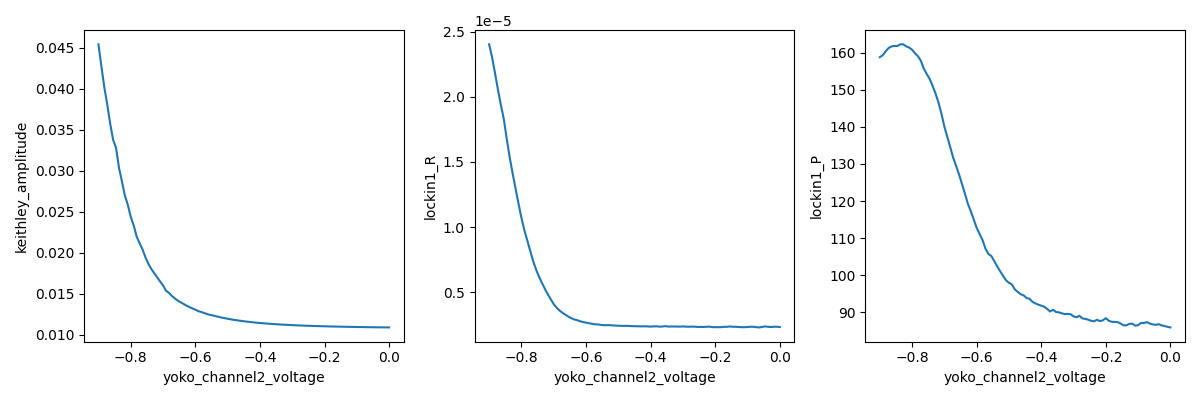

2024-11-26 16:52:00,668 [INFO] Completed in 0h 0m 45s
2024-11-26 16:52:00,668 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\3\data.tsv.gz


In [17]:
# Run experiment 
START = 0
STOP = -0.900
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

In [18]:
paramp(vg), paramp(vdd)

(None, None)

In [19]:
V1.voltage(0)

In [20]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	REMOTE 
 rror        :	0 - No Error
frequency    :	50003 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


In [21]:
V1.voltage(50)

In [22]:
vdd(0.1)

2024-11-26 17:01:24,426 [INFO] Starting sweep with ID 4
2024-11-26 17:01:24,427 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

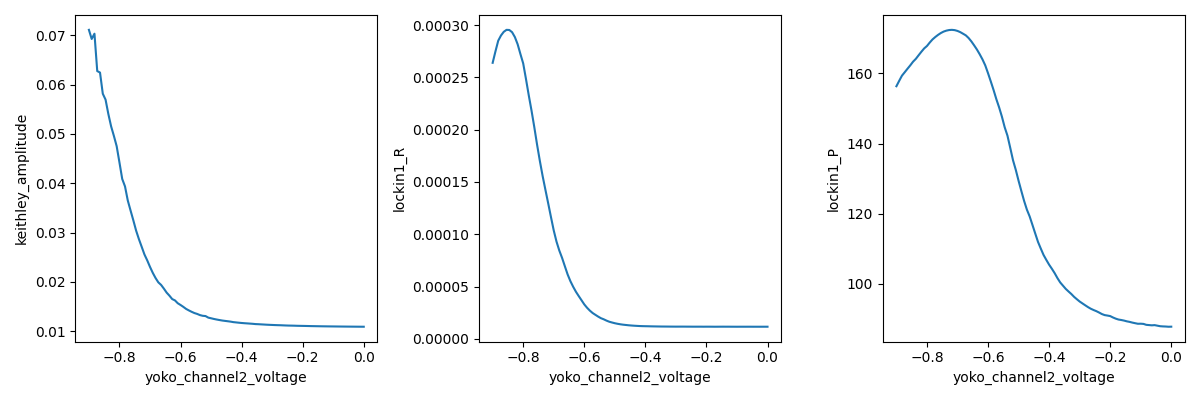

2024-11-26 17:02:09,972 [INFO] Completed in 0h 0m 45s
2024-11-26 17:02:09,980 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\4\data.tsv.gz


In [23]:
# Run experiment 
START = 0
STOP = -0.900
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

In [25]:
temptemp()

299.367027284

In [24]:
# Look at result metadate for verification 
from sweep.sweep_load import pload1d

data = pload1d(datapath, 4)
Gout_R = data[Gout.R.full_name]
Vgs = data[vg.full_name]

dc_bias = Vgs[np.argmax(Gout_R)]
print(dc_bias, np.max(Gout_R))

-0.85455 0.00029539183015


In [26]:
vg(dc_bias)

In [66]:
## Balancing arguments
FREQ = 50000
DELTA = (180, 180)
INITIAL = (10, 10)
Cstand = 1  # pF
DRIVE = 100

In [28]:
balancer = Balancer(acdac.ch1, acdac.ch4, acdac.ch2, Gout, acdac.frequency) # ch1 = control, ch4 = reference, ch2 = drive

In [29]:
balancer.excite(DRIVE, 400, FREQ)

In [30]:
null_voltages = balancer.balance(INITIAL, DELTA, null=True)
c_meas = balancer.calculate_capacitance(Cstand)
print(f"null voltages = {null_voltages}")
print(f"Balance Point Capacitance: {c_meas} nF")

Kr1, Kr2 = (np.float64(-1.861325876666665e-05), np.float64(-5.081318729611111e-05))
Kc1, Kc2 = (np.float64(4.796472442166667e-05), np.float64(-1.9061304909444447e-05))
P = 0.1270733310903651
null voltages = (np.float64(169.68688742015976), np.float64(-121.66680686389122))
Balance Point Capacitance: 1.6968688742015976 nF


In [45]:
class Capacitance():
    def __init__(self, calc, balance, init = INITIAL, delta = DELTA, Cstand = Cstand):
        self.balance = balance
        self.calc = calc
        self.init = init 
        self.delta = delta
        self.Cstand = Cstand
        self.full_name = "capacitance"

    def get(self):
        self.balance(self.init, self.delta, null=True)
        c_meas = self.calc(self.Cstand)
        return float(c_meas)
    
    __call__ = get

cap = Capacitance(balancer.calculate_capacitance, balancer.balance)

In [46]:
l = cap()

Kr1, Kr2 = (np.float64(-1.6606655761111106e-05), np.float64(-4.536761808722223e-05))
Kc1, Kc2 = (np.float64(4.776296818333334e-05), np.float64(-2.0153004401111113e-05))
P = 0.13378579356857254


In [47]:
l

3.711159728254378

In [48]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	REMOTE 
 rror        :	0 - No Error
frequency    :	50000 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	-167.96 (deg)
voltage :	379.47 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	100 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)


In [ ]:
# sets = np.linspace(0, 400, 40)
# curr_min = np.inf 
# for setx in sets:
#     acdac.ch2.voltage(setx)
#     sleep(0.5)
#     curr_min = min(curr_min, Gout.P())

# print(curr_min)

In [49]:
paramp(vdd)
paramp(vg)

In [50]:
V1.voltage(0), V2.voltage(0)

(None, None)

In [52]:
li2.X.label = "therm_X"
li2.Y.label = "therm_Y"
prams = [temptemp, Gout.aux_in0, li2.X, li2.Y]
mc2 = {}
for param in prams:
    mc2[param.full_name] = param.label
s2 = sweep.Station(basedir=datapath, measurement_config=mc2) 
s2.add_comment("temp test")

for p in prams:
    s2.fp(p)

In [53]:
for pram in prams:
    s2.plot("time", pram)

2024-11-26 17:38:35,717 [INFO] Starting watch with ID 6
2024-11-26 17:38:44,469 [WARNING] ID 6 INTERRUPTED


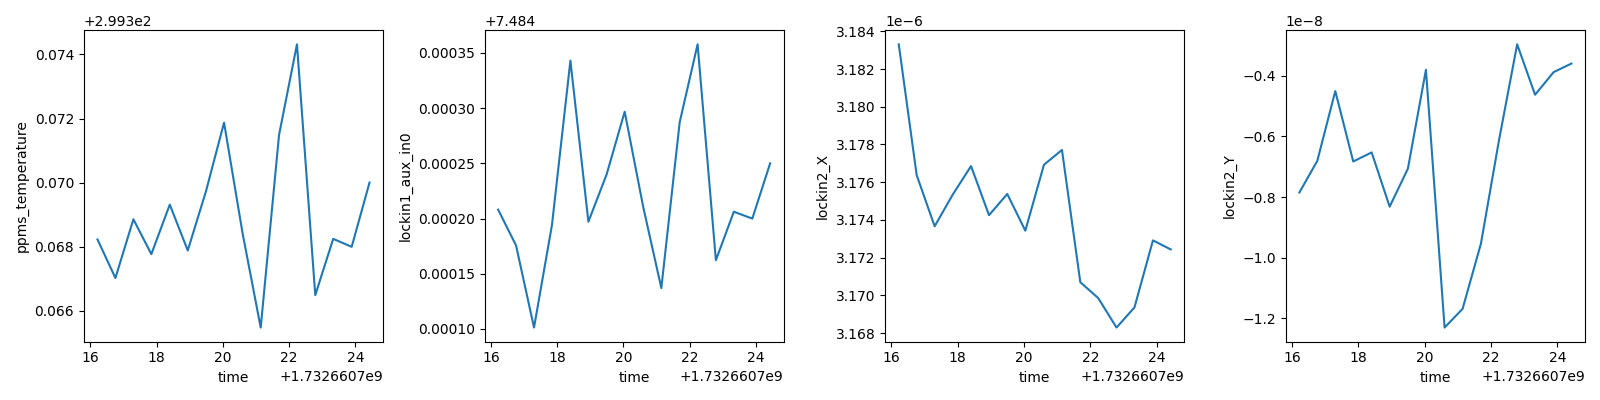

2024-11-26 17:38:44,834 [INFO] Completed in 0h 0m 8s
2024-11-26 17:38:44,835 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\6\data.tsv.gz


In [ ]:

s2.watch(delay=5)

In [ ]:
li2.X.label = "therm_X"
li2.Y.label = "therm_Y"
prams = [temptemp, Gout.aux_in0, li2.X, li2.Y]
mc2 = {}
for param in prams:
    mc2[param.full_name] = param.label
s3 = sweep.Station(basedir=datapath, measurement_config=mc2) 
s3.add_comment("temp overnight test")

for p in prams:
    s3.fp(p)

s3.watch(delay=5)

2024-11-26 17:42:05,504 [INFO] Starting watch with ID 7


In [48]:
#opening data from overnight sweep Eames 11/27/2024

from sweep.sweep_load import pload1d
import datetime 
from time import strftime, localtime
import numpy as np
import matplotlib.pyplot as plt

# Path to your TSV.gz file
idx = 7
file_path = datapath  
data = pload1d(file_path, idx)

td = data['time'] - data['time'][0]
lt = datetime.datetime.fromtimestamp(data["time"][-1]).strftime('%c')
print(lt)
plt.plot(td, data['ppms_temperature'])
plt.xlabel('Time (s)')
plt.ylabel('PPMS Temperature (K)')

plots_path = datapath / f"{idx}" / "plots"
plt.savefig(plots_path / "Temp_vs_time.png", bbox_inches='tight')
plt.show()

Wed Nov 27 00:28:27 2024


In [49]:
type(data.keys())

dict_keys

In [51]:
vdd(0.1)

## Finding new balance point at 2K

In [56]:
s.read_all()

2024-11-27 11:46:11,713 [INFO] Reading all parameters:
2024-11-27 11:46:12,147 [INFO] Reading yoko_channel2_voltage: 0.0
2024-11-27 11:46:12,167 [INFO] Reading keithley_amplitude: 0.001974623
2024-11-27 11:46:12,176 [INFO] Reading lockin1_R: 1.380298098e-08
2024-11-27 11:46:12,188 [INFO] Reading lockin1_P: 46.911762238


In [57]:
V1.voltage(100)

2024-11-27 11:48:14,220 [INFO] Starting sweep with ID 8
2024-11-27 11:48:14,220 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

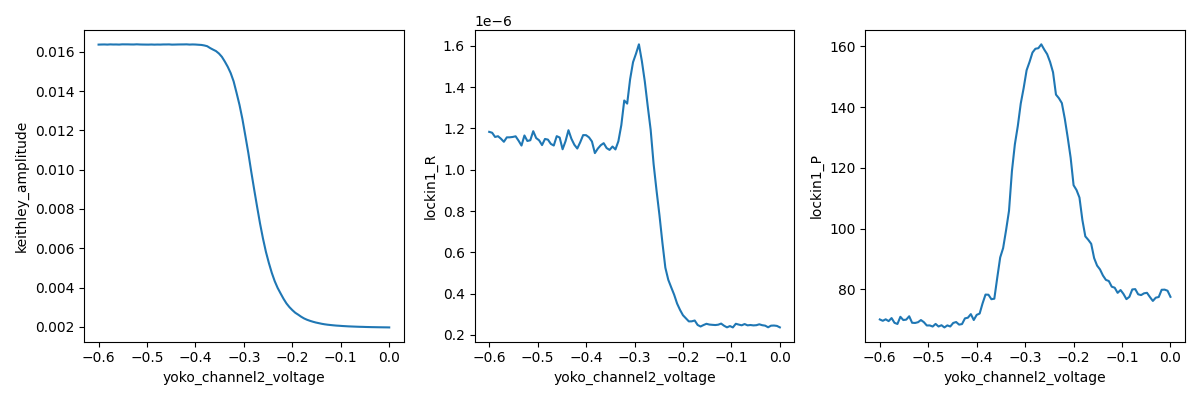

2024-11-27 11:49:00,219 [INFO] Completed in 0h 0m 45s
2024-11-27 11:49:00,223 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\8\data.tsv.gz


In [58]:
# Run experiment 
START = 0
STOP = -0.600
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

2024-11-27 11:52:55,031 [INFO] Starting sweep with ID 9
2024-11-27 11:52:55,032 [INFO] Minimum duration 0h 0m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

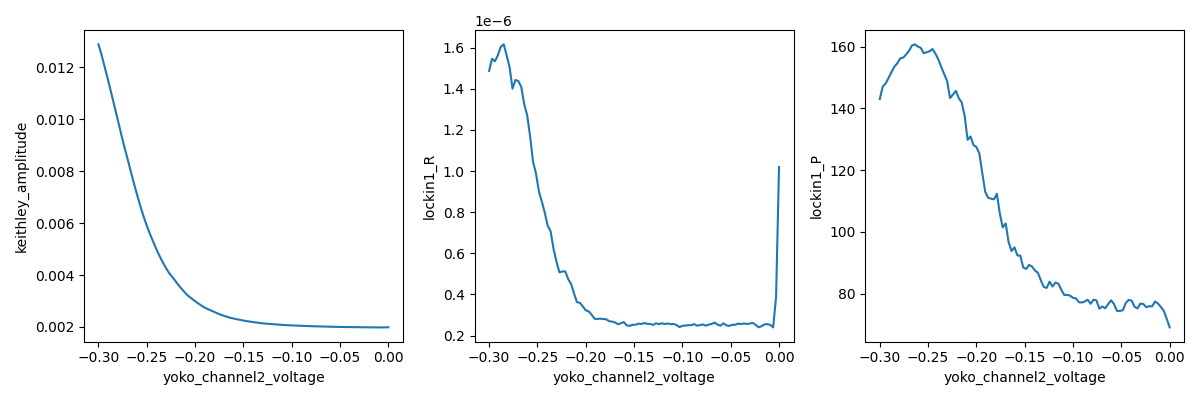

2024-11-27 11:53:40,714 [INFO] Completed in 0h 0m 45s
2024-11-27 11:53:40,714 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\9\data.tsv.gz


In [59]:
# Run experiment 
START = 0
STOP = -0.300
SAMPLES = 100
INT_TIME = 0.4

# s.watch(delay = INT_TIME, max_duration=10)
setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(vg, setpoints, delay=INT_TIME)

In [61]:
data = pload1d(datapath, 9)
Gout_R = data[Gout.R.full_name]
Vgs = data[vg.full_name]

dc_bias2K = Vgs[np.argmax(Gout_R)]
print(dc_bias2K, np.max(Gout_R))

-0.28485 1.6163063492e-06


In [78]:
V1.voltage(10), V2.voltage(0)

(None, None)

In [80]:
V1.phase(0)

In [63]:
vg(dc_bias2K)

In [64]:
balancer = Balancer(acdac.ch1, acdac.ch4, acdac.ch2, Gout, acdac.frequency) # ch1 = control, ch4 = reference, ch2 = drive

In [67]:
balancer.excite(DRIVE, 400, FREQ)

In [70]:
null_voltages = balancer.balance(INITIAL, DELTA, null=True)
c_meas = balancer.calculate_capacitance(Cstand)
print(f"null voltages = {null_voltages}")
print(f"Balance Point Capacitance: {c_meas} pF")

Kr1, Kr2 = (np.float64(-0.0007182738045555563), np.float64(-0.0014504849281666667))
Kc1, Kc2 = (np.float64(0.0014454056832222217), np.float64(-0.0007239143896055556))
P = 0.19872622686035762
null voltages = (np.float64(322.1848214486766), np.float64(-124.16312211468741))
Balance Point Capacitance: 3.2218482144867657 pF


In [74]:
5 * balancer.calculate_capacitance(Cstand)

np.float64(16.10924107243383)

In [82]:
acdac.frequency.vals

<Numbers 0<=v<=1000000.0>

# Bode Sweep. Freq 0-100kHz

In [99]:
V2.voltage(0)
V1.voltage(10)
V1.phase(0)

exps = np.linspace(1,5, 40)
freqs = 10**exps

In [88]:
# measurement config for analysis 
ips = [acdac.frequency]

dps = [li1.R, li1.P]
mc = {}
for param in ips + dps:
    mc[param.full_name] = param.label

sf = sweep.Station(basedir=datapath, measurement_config=mc)
for param in ips + dps:
    sf.fp(param)

s.add_comment("Bode Sweep: Frequency 0-100kHz")

In [89]:
for dp in dps:
    sf.plot(acdac.frequency, dp)

In [100]:
print(freqs)

[1.00000000e+01 1.26638017e+01 1.60371874e+01 2.03091762e+01
 2.57191381e+01 3.25702066e+01 4.12462638e+01 5.22334507e+01
 6.61474064e+01 8.37677640e+01 1.06081836e+02 1.34339933e+02
 1.70125428e+02 2.15443469e+02 2.72833338e+02 3.45510729e+02
 4.37547938e+02 5.54102033e+02 7.01703829e+02 8.88623816e+02
 1.12533558e+03 1.42510267e+03 1.80472177e+03 2.28546386e+03
 2.89426612e+03 3.66524124e+03 4.64158883e+03 5.87801607e+03
 7.44380301e+03 9.42668455e+03 1.19377664e+04 1.51177507e+04
 1.91448198e+04 2.42446202e+04 3.07029063e+04 3.88815518e+04
 4.92388263e+04 6.23550734e+04 7.89652287e+04 1.00000000e+05]


2024-11-27 12:42:24,542 [INFO] Starting sweep with ID 13
2024-11-27 12:42:24,543 [INFO] Minimum duration 0h 0m 20s


  0%|          | 0/40 [00:00<?, ?it/s]

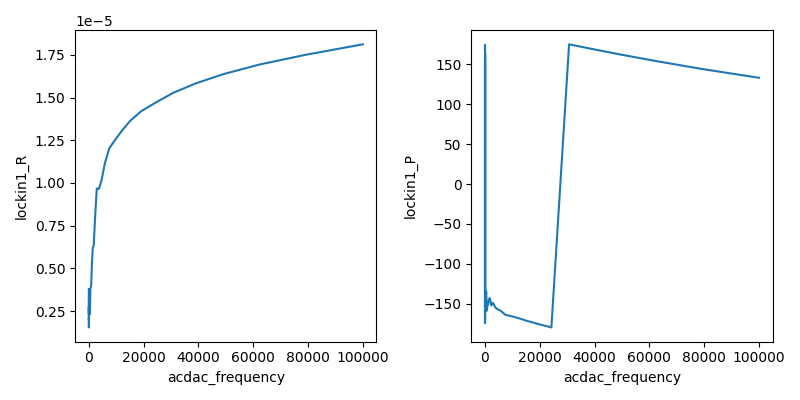

2024-11-27 12:42:47,064 [INFO] Completed in 0h 0m 22s
2024-11-27 12:42:47,064 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\13\data.tsv.gz


In [101]:
sf.sweep(acdac.frequency, setpoints=freqs, delay=0.5)

In [110]:
d = pload1d(datapath, 13)
posD = d[li1.P.full_name] + (360 * (d[li1.P.full_name] < 0))

plt.plot(freqs, posD)
plt.show()

## On CH2, with Reference (sample) Capacitor 

In [104]:
V1.voltage(0), V2.voltage(10)

(None, None)

2024-11-27 12:46:54,455 [INFO] Starting sweep with ID 14
2024-11-27 12:46:54,457 [INFO] Minimum duration 0h 0m 20s


  0%|          | 0/40 [00:00<?, ?it/s]

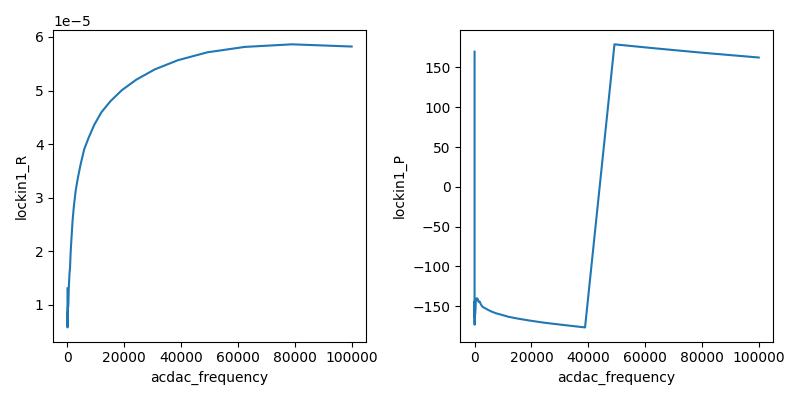

2024-11-27 12:47:17,012 [INFO] Completed in 0h 0m 22s
2024-11-27 12:47:17,014 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data\14\data.tsv.gz


In [105]:
sf.sweep(acdac.frequency, setpoints=freqs, delay=0.5)

In [111]:
V1.voltage(10)

In [112]:
print("Helllo")

Helllo
